In [17]:
import numpy as np # numpy  1.15.4
import pandas as pd # pandas   0.23.4 

from catboost import CatBoostRegressor # catboost   0.11.1
from sklearn.decomposition import PCA # scikit-learn   0.20.0
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [18]:
# Блок обозначения переменных
names = ['pressure_he', 'coke','temp','pressure','activity']
paths1 = ['data/pressure_he_target.csv','data/coke_target.csv','data/temp_on_he_target.csv','data/reactor_pressure_target.csv','data/activity_target.csv']
paths2 = ['data/pressure_he_sample_submission.csv','data/coke_sample_submission.csv','data/temp_on_he_sample_submission.csv','data/reactor_pressure_sample_submission.csv','data/activity_sample_submission.csv']
dict1 = {name:list_path for name,list_path in zip(names,zip(paths1,paths2))}

# Признаки показавшие нулевой импотанс
list_bad_isnull = ['f_1_isnull', 'f_5_isnull', 'f_6_isnull', 'f_7_isnull', 'f_8_isnull',
       'f_9_isnull', 'f_10_isnull', 'f_11_isnull', 'f_12_isnull',
       'f_13_isnull', 'f_14_isnull', 'f_15_isnull', 'f_16_isnull',
       'f_17_isnull', 'f_18_isnull', 'f_19_isnull', 'f_20_isnull',
       'f_22_isnull', 'f_23_isnull', 'f_24_isnull', 'f_26_isnull',
       'f_27_isnull', 'f_31_isnull', 'f_32_isnull', 'f_37_isnull',
       'f_38_isnull', 'f_44_isnull', 'f_45_isnull'] 

# Период остановки
bad_time = list(range(7526,7854)) 

In [20]:
# Загрузка, обработка данных и генерация новых фичей
sensors = pd.read_csv('data/sensors.csv').drop(['timestamp'],axis = 1)


# Заменяю сильно коррелирующие фичи заменяю их на разность 
columns_to_diff = list(sensors.columns)
for col in columns_to_diff:
    for col2 in sensors.corr()[sensors.corr()[col]>0.65].index:
        if col2!=col:
            sensors[col+'_'+col2+'_diff'] = MinMaxScaler().fit(sensors[col].loc[:10399].values.reshape(len(sensors.loc[:10399]),1)).transform(sensors[col].values.reshape(len(sensors),1)) - MinMaxScaler().fit(sensors[col2].loc[:10399].values.reshape(len(sensors.loc[:10399]),1)).transform(sensors[col2].values.reshape(len(sensors),1))
            sensors.drop(col2,axis =1, inplace = True)
            columns_to_diff.remove(col2)

# Если до сих пор остались сильно коррелирующие фичи - удаляю их
columns_to_diff = list(sensors.columns)
for col in columns_to_diff:
    for col2 in sensors.corr()[sensors.corr()[col]>0.95].index:
        if col2!=col:
            sensors.drop(col2,axis =1, inplace = True)
            columns_to_diff.remove(col2)


# Если пропусков меньше 7000, то добавляю преобразованную колонку:
# беру по w предыдущих строк min, max, std, mean,
# беру разность с предыдущим, -12ым, -24ым,
# добавляю колонку пропущенно ли значение, если оно не нулевого импотанса в последствии
columns = sensors.columns
for col in columns:
    sum1 = sum(sensors[col].isnull())
    if sum1 == 0:
        continue
    if sum1<7000:
        window_size = [5,10,15,20,50,100,150,300]
        for w in window_size:
            sensors[col+'_rollingmean_'+str(w)]=sensors[col].rolling(window=w,center=False).mean()
            sensors[col+'_rollingmax_'+str(w)]=sensors[col].rolling(window=w,center=False).max()
            sensors[col+'_rollingmin_'+str(w)]=sensors[col].rolling(window=w,center=False).min()
            sensors[col+'_rollingstd_'+str(w)]=sensors[col].rolling(window=w,center=False).std()
            
        for delta in [24,12,1]:
            sensors[col+'_'+str(delta)] = sensors[col] - sensors[col].shift(delta)
            
    if col+'_isnull' not in list_bad_isnull:
        sensors[col+'_isnull'] = sensors[col].isnull().astype(int)

        
# Сжимаю все получившееся PCA, беру полученные переменные и исходный датасет 
# Два PCA почему-то показали лучшую эффективность, видимо, из-за перетягивания важности на себя 
pca = PCA(n_components=10,random_state = 1)
pca.fit(sensors.loc[:10399].fillna(0))
pca1 = PCA(n_components=4,random_state = 1)
pca1.fit(sensors.loc[:10399].fillna(0))
sensors = pd.concat([pd.read_csv('data/sensors.csv'),
                     pd.DataFrame(pca.transform(sensors.fillna(0))),
                     pd.DataFrame(pca1.transform(sensors.fillna(0)))
                    ],axis = 1)

# Добавляю категориальные переменные дня недели, месяца и часа суток
sensors = pd.concat([
                    sensors,
                    pd.get_dummies(sensors.timestamp.apply(lambda x:pd.to_datetime(x).month)),
                    pd.get_dummies(sensors.timestamp.apply(lambda x:pd.to_datetime(x).hour)),
                    pd.get_dummies(sensors.timestamp.apply(lambda x:pd.to_datetime(x).day_name())),
                    ],axis = 1)

# Добавляю информацию о пропущенном значении не нулевого импотанса.
for col in sensors.columns:
    sum1 = sum(sensors[col].isnull())
    if sum1 == 0 or type(col)!=str:
        continue
    if col+'_isnull' not in list_bad_isnull:
        sensors[col+'_isnull'] = sensors[col].isnull().astype(int)

sensors.fillna(0,inplace = True)


tags = pd.read_csv('data/tags.csv')

In [10]:
# Подгружаю target и объединяю его с полученными фичями 
name = 'activity'
path1, path2 = dict1[name]

train = pd.read_csv(path1)
test = pd.read_csv(path2)

train = pd.concat([train,sensors.drop('timestamp',axis = 1).iloc[:len(train)]],axis = 1).drop(bad_time,axis =0)
test = pd.concat([test,sensors.drop('timestamp',axis = 1).iloc[-len(test):].reset_index(drop=True)],axis = 1)
train.target = train.target

# Predict

In [11]:
# Формирую датасет для обучения и датасет для прогноза
x_train, y_train = train.drop(['timestamp','target'],axis = 1),train['target']
x_test, y_test = test.drop(['timestamp','target'],axis = 1),test['target']

In [22]:
x_train.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_34_isnull,f_35_isnull,f_36_isnull,f_39_isnull,f_40_isnull,f_41_isnull,f_42_isnull,f_43_isnull,f_46_isnull,f_47_isnull
0,0.000000,0.000000,0.000000,-0.005383,6.251910,0.022304,1.466704,11.173872,236232.328494,239141.739468,...,0,0,1,1,1,1,1,0,0,0
1,0.000000,0.000000,0.000000,0.103383,6.465077,0.011693,1.267009,12.987551,236736.358537,237598.686177,...,0,0,1,1,1,1,1,0,0,0
2,0.000000,0.000000,0.000000,-0.004852,6.315273,-0.003072,1.216848,12.824779,235780.400580,238313.969270,...,0,0,1,1,1,1,1,0,0,0
3,0.000000,0.000000,0.000000,0.131502,6.437954,-0.012240,1.162371,6.678317,236091.381252,238923.480515,...,0,0,1,1,1,1,1,0,0,0
4,98.912665,0.336871,27.897405,0.018193,6.217860,0.015535,1.287526,5.741191,234844.641480,237358.261098,...,0,0,1,1,1,1,1,0,0,0


In [12]:
# Обучаю модель 
model = CatBoostRegressor(  
                            random_seed = 1,
                            learning_rate = 0.0015,
                            depth = 3,
                            l2_leaf_reg = 0.00001,
                            iterations = 8000,
                            verbose = False,
                            loss_function = 'RMSE',
                            eval_metric = 'MAE'
)
model.fit(x_train, y_train)

In [14]:
# Деляю прогноз и созраняю предсказания
train1 = pd.read_csv(path1)
test1 = pd.read_csv(path2)
test1['target'] = model.predict(x_test)
test1.to_csv('result/'+name+'_result.csv',index = False)

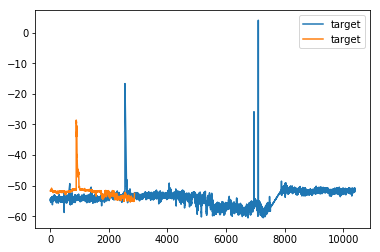

In [15]:
# Отображаю его
pd.concat([train1,test1],axis = 1).reset_index(drop = True).plot()